In [2]:
%pip install jax

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: Loading egg at /global/common/software/nersc9/pytorch/2.3.1/lib/python3.11/site-packages/torchvision-0.18.0a0+6043bc2-py3.11-linux-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
  Using cached jax-0.4.38-py3-none-any.whl.metadata (22 kB)
  Using cached jaxlib-0.4.38-cp311-cp311-manylinux2014_x86_64.whl.metadata (1.0 kB)
  Using cached ml_dtypes-0.5.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (21 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
Using cached jax-0.4.38-py3-none-any.whl (2.2 MB)
Using cached jaxlib-0.4.38-cp311-cp311-manylinux2014_x86_64.whl (101.8 MB)
Using cached ml_dtypes-0.5.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.7 MB)
Using cached opt_einsum-3.4.0-py3-n

In [7]:
import pennylane as qml
import jax
from jax import numpy as np
# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms

jax.config.update("jax_platform_name", "cpu")


In [10]:
dev = qml.device("default.qubit", wires=2)

x = np.array([0.1, 0.2, 0.3])

@qml.qnode(dev, diff_method="adjoint")
def circuit(a):
    qml.RX(a[0], wires=0)
    qml.CNOT(wires=(0,1))
    qml.RY(a[1], wires=1)
    qml.RZ(a[2], wires=1)
    return qml.expval(qml.PauliX(wires=1))

In [11]:
dev


<default.qubit device (wires=2) at 0x7fd0ac3ccf10>

In [12]:
n_gates = 4
n_params = 3

ops = [
    qml.RX(x[0], wires=0),
    qml.CNOT(wires=(0,1)),
    qml.RY(x[1], wires=1),
    qml.RZ(x[2], wires=1)
]
M = qml.PauliX(wires=1)

In [13]:
from pennylane.devices.qubit import create_initial_state, apply_operation

state = create_initial_state((0, 1))

for op in ops:
    state = apply_operation(op, state)
    
print(state)

[[9.8260182e-01-0.14850575j 9.8589033e-02+0.01490028j]
 [7.4563531e-04+0.00493356j 7.4314815e-03-0.04917107j]]


/global/homes/g/gzquse/.local/perlmutter/pytorch2.3.1/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:118: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in astype is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)
/global/homes/g/gzquse/.local/perlmutter/pytorch2.3.1/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:118: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in astype is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, 

In [14]:
bra = apply_operation(M, state)
ket = state

In [15]:
ket

Array([[9.8260182e-01-0.14850575j, 9.8589033e-02+0.01490028j],
       [7.4563531e-04+0.00493356j, 7.4314815e-03-0.04917107j]],      dtype=complex64)

In [16]:
M_expval = np.vdot(bra, ket)
print("vdot", M_expval)
print("Qnode", circuit(x))

vdot (0.18884788+7.275958e-12j)
Qnode 0.18884787


In [17]:
bra_n = create_initial_state((0, 1))

for op in ops:
    bra_n = apply_operation(op, bra_n)
bra_n = apply_operation(M, bra_n)
bra_n = apply_operation(qml.adjoint(ops[-1]), bra_n)

ket_n = create_initial_state((0, 1))

for op in ops[:-1]: # don't apply last operation
    ket_n = apply_operation(op, ket_n)

M_expval_n = np.vdot(bra_n, ket_n)
print(M_expval_n)

(0.18884787-1.8626451e-09j)


/global/homes/g/gzquse/.local/perlmutter/pytorch2.3.1/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:118: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in astype is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)
/global/homes/g/gzquse/.local/perlmutter/pytorch2.3.1/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:118: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in astype is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, 

In [18]:
bra_n_v2 = apply_operation(M, state)
ket_n_v2 = state

adj_op = qml.adjoint(ops[-1])

bra_n_v2 = apply_operation(adj_op, bra_n_v2)
ket_n_v2 = apply_operation(adj_op, ket_n_v2)

M_expval_n_v2 = np.vdot(bra_n_v2, ket_n_v2)
print(M_expval_n_v2)

(0.18884787-1.877197e-09j)


/global/homes/g/gzquse/.local/perlmutter/pytorch2.3.1/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:118: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in astype is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)
/global/homes/g/gzquse/.local/perlmutter/pytorch2.3.1/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:118: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in astype is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, 

In [11]:
bra_loop = apply_operation(M, state)
ket_loop = state

for op in reversed(ops):
    adj_op = qml.adjoint(op)
    bra_loop = apply_operation(adj_op, bra_loop)
    ket_loop = apply_operation(adj_op, ket_loop)
    print(np.vdot(bra_loop, ket_loop))

(0.18884787-1.8626451e-09j)
(0.1888479-1.0121918e-09j)
(0.1888479-1.0121918e-09j)
(0.18884791-1.0121919e-09j)


In [14]:
grad_op0 = qml.operation.operation_derivative(ops[0])
print(grad_op0)

[[-0.02498958+0.j          0.        -0.49937513j]
 [ 0.        -0.49937513j -0.02498958+0.j        ]]


In [11]:
bra = apply_operation(M, state)
ket = state

grads = []

for op in reversed(ops):
    adj_op = qml.adjoint(op)
    ket = apply_operation(adj_op, ket)

    # Calculating the derivative
    if op.num_params != 0:
        dU = qml.operation.operation_derivative(op)
        ket_temp = apply_operation(qml.QubitUnitary(dU, op.wires), ket)

        dM = 2 * np.real(np.vdot(bra, ket_temp))
        grads.append(dM)

    bra = apply_operation(adj_op, bra)


# Finally reverse the order of the gradients
# since we calculated them in reverse
grads = grads[::-1]

print("our calculation: ", [float(grad) for grad in grads])

grad_compare = jax.grad(circuit)(x)
print("comparison: ", grad_compare)

our calculation:  [-0.018947992473840714, 0.9316158890724182, -0.05841750279068947]
comparison:  [-0.01894799  0.93161577 -0.0584175 ]


In [12]:
dev_lightning = qml.device('lightning.qubit', wires=2)

@qml.qnode(dev_lightning, diff_method="adjoint")
def circuit_adjoint(a):
    qml.RX(a[0], wires=0)
    qml.CNOT(wires=(0,1))
    qml.RY(a[1], wires=1)
    qml.RZ(a[2], wires=1)
    return qml.expval(M)

print(jax.grad(circuit_adjoint)(x))

[-0.01894799  0.93161577 -0.0584175 ]


FileNotFoundError: [Errno 2] No such file or directory: 'adjoint_diff/scaling.png'

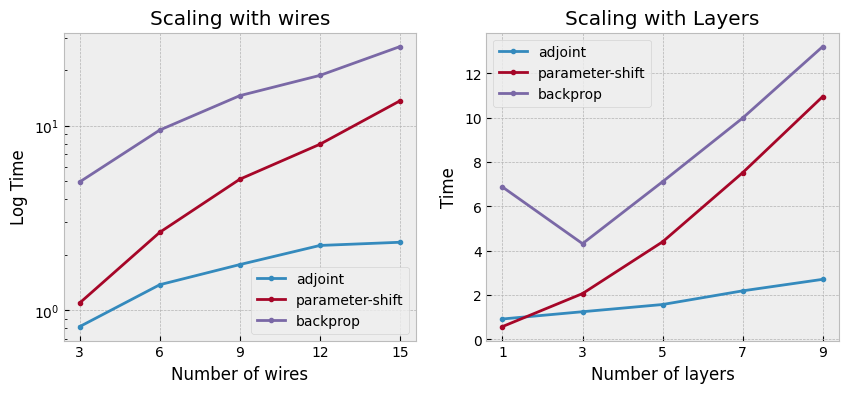

In [13]:
import timeit
import matplotlib.pyplot as plt
import pennylane as qml
import jax

jax.config.update("jax_platform_name", "cpu")
jax.config.update('jax_enable_x64', True)

plt.style.use("bmh")

n_samples = 5


def get_time(qnode, params):
    globals_dict = {'grad': jax.grad, 'circuit': qnode, 'params': params}
    return timeit.timeit("grad(circuit)(params)", globals=globals_dict, number=n_samples)


def wires_scaling(n_wires, n_layers):
    key = jax.random.PRNGKey(42)

    t_adjoint = []
    t_ps = []
    t_backprop = []

    def circuit(params, wires):
        qml.StronglyEntanglingLayers(params, wires=range(wires))
        return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1) @ qml.PauliZ(2))

    for i_wires in n_wires:
        dev = qml.device("lightning.qubit", wires=i_wires)
        dev_python = qml.device("default.qubit", wires=i_wires)

        circuit_adjoint = qml.QNode(lambda x: circuit(x, wires=i_wires), dev, diff_method="adjoint")
        circuit_ps = qml.QNode(lambda x: circuit(x, wires=i_wires), dev, diff_method="parameter-shift")
        circuit_backprop = qml.QNode(lambda x: circuit(x, wires=i_wires), dev_python, diff_method="backprop")

        # set up the parameters
        param_shape = qml.StronglyEntanglingLayers.shape(n_wires=i_wires, n_layers=n_layers)
        params = jax.random.normal(key, param_shape)

        t_adjoint.append(get_time(circuit_adjoint, params))
        t_backprop.append(get_time(circuit_backprop, params))
        t_ps.append(get_time(circuit_ps, params))

    return t_adjoint, t_backprop, t_ps


def layers_scaling(n_wires, n_layers):
    key = jax.random.PRNGKey(42)

    dev = qml.device("lightning.qubit", wires=n_wires)
    dev_python = qml.device('default.qubit', wires=n_wires)

    t_adjoint = []
    t_ps = []
    t_backprop = []

    def circuit(params):
        qml.StronglyEntanglingLayers(params, wires=range(n_wires))
        return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1) @ qml.PauliZ(2))

    circuit_adjoint = qml.QNode(circuit, dev, diff_method="adjoint")
    circuit_ps = qml.QNode(circuit, dev, diff_method="parameter-shift")
    circuit_backprop = qml.QNode(circuit, dev_python, diff_method="backprop")

    for i_layers in n_layers:
        # set up the parameters
        param_shape = qml.StronglyEntanglingLayers.shape(n_wires=n_wires, n_layers=i_layers)
        params = jax.random.normal(key, param_shape)

        t_adjoint.append(get_time(circuit_adjoint, params))
        t_backprop.append(get_time(circuit_backprop, params))
        t_ps.append(get_time(circuit_ps, params))

    return t_adjoint, t_backprop, t_ps


if __name__ == "__main__":
    layers_list = [1, 3, 5, 7, 9]
    n_wires = 5
    adjoint_layers, backprop_layers, ps_layers = layers_scaling(n_wires, layers_list)

    wires_list = [3, 6, 9, 12, 15]
    n_layers = 3
    adjoint_wires, backprop_wires, ps_wires = wires_scaling(wires_list, n_layers)

    # Generating the graphic
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    ax1.plot(wires_list, adjoint_wires, '.-', label="adjoint")
    ax1.plot(wires_list, ps_wires, '.-', label="parameter-shift")
    ax1.plot(wires_list, backprop_wires, '.-', label="backprop")

    ax1.legend()

    ax1.set_xlabel("Number of wires")
    ax1.set_xticks(wires_list)
    ax1.set_ylabel("Log Time")
    ax1.set_yscale("log")
    ax1.set_title("Scaling with wires")

    ax2.plot(layers_list, adjoint_layers, '.-', label="adjoint")
    ax2.plot(layers_list, ps_layers, '.-', label="parameter-shift")
    ax2.plot(layers_list, backprop_layers, '.-', label="backprop")

    ax2.legend()

    ax2.set_xlabel("Number of layers")
    ax2.set_xticks(layers_list)
    ax2.set_ylabel("Time")
    ax2.set_title("Scaling with Layers")

    plt.savefig("adjoint_diff/scaling.png")